# Evaluate and fit a ML model on the EC flux tower data 



## Load modules

In [1]:
import os
import shap
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sb
from joblib import dump
import multiprocessing
from pprint import pprint
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

import sys
sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools')
from dea_tools.classification import spatial_clusters

import warnings
warnings.filterwarnings("ignore")

## Analysis Parameters

In [2]:
model_name = 'AUS'
model_var = 'GPP'

scoring='neg_mean_absolute_error'
cluster_method = 'Hierarchical'
max_distance = 0.0000001 # map degrees

In [3]:
ncpus=multiprocessing.cpu_count()
print('ncpus = '+str(ncpus))

ncpus = 16


## Prepare Data

In [4]:
base = '/g/data/os22/chad_tmp/NEE_modelling/results/training_data/'
sites = os.listdir('/g/data/os22/chad_tmp/NEE_modelling/results/training_data/')

td = []
for site in sites:
    if '.csv' in site:
        xx = pd.read_csv(base+site, index_col='time', parse_dates=True)
        xx['site'] = site[0:5]
        td.append(xx)

ts = pd.concat(td).dropna()

## Modelling

In [5]:
# columns = ['Ta_EC', 'Precip_EC', 'Fsd_EC', 'VPD_EC', 'LAI_RS', 'EVI_RS', 'LST_RS', 'FPAR_RS',
#    'tree_cover_RS', 'nontree_cover_RS', 'nonveg_cover_RS', 'LST-Tair_RS',
#    'MI_RS', 'precip_cml_3_RS', 'precip_cml_6_RS', 'TWI_RS']

In [6]:
xx = []
yy = []
cc = []
dfs = []
for t in td:
    # t = t.drop('PFT_RS', axis=1)
    t = t.dropna()  # remove NaNS
    coords = t[['x_coord','y_coord']] #extract coords
    t = t.drop(['x_coord','y_coord','PFT_RS', 'site'] , axis=1) # drop coords and Landcover
    df = t.drop(['NEE_SOLO_EC','GPP_SOLO_EC','ER_SOLO_EC'], axis=1) # seperate carbon fluxes
    
    df = df.filter(regex='RS') # only use remote sensing variables   
    #df = df[columns]
    # Write out predictior variables to text file
    textfile = open("/g/data/os22/chad_tmp/NEE_modelling/results/variables.txt", "w")
    for element in df.columns:
        textfile.write(element + ",")
    textfile.close()
    
    if model_var == 'ET':
        df_var=t[model_var+'_EC']
    else:
        df_var=t[model_var+'_SOLO_EC'] # seperate out the variable we're modelling

    x = df.reset_index(drop=True)#.to_numpy()
    y = df_var.reset_index(drop=True)#.to_numpy()
    c = coords.reset_index(drop=True)
    xx.append(x)
    yy.append(y)
    cc.append(c)
    
x = np.concatenate([x for x in xx])
y = np.concatenate([y for y in yy])
c = np.concatenate([c for c in cc])

print(x.shape)

(2717, 16)


## Test model robustness with nested spatial leave-one-group-out cross validation

### Visualising spatial groupings

After setting the parameters, lets first generate spatial clusters using the DE Africa function spatial_clusters to visualize how our data will be grouped when running SKCV in the next step. You may want to refine the parameters to achieve a grouping that works for your dataset by resetting the parameters above


In [7]:
aus=gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/aus_outline/AUS_2021_AUST_GDA2020.shp')

n clusters = 28


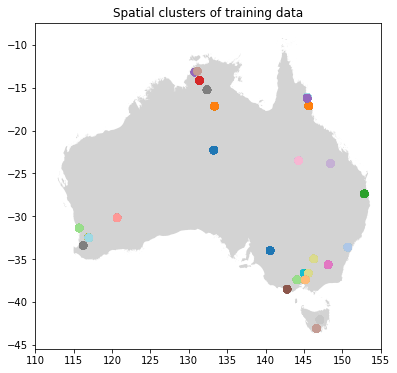

In [8]:
#create clustes
spatial_groups = spatial_clusters(coordinates=c,
                                  method=cluster_method,
                                  max_distance=max_distance,
                                  n_groups=None,
                                  verbose=True)

#plot
fig, ax = plt.subplots(1,1, figsize=(10,6))
aus[aus.AUS_CODE21=='AUS'].plot(ax=ax, color='lightgrey')
ax.scatter(c[:, 0], c[:, 1], c=spatial_groups,
            s=50, cmap='tab20');
ax.set_xlim(110,155)
plt.title('Spatial clusters of training data');

In [9]:
# Create the parameter grid based on the results of random search 
param_grid = {
    # 'max_depth': [None, 10, 20, 30],
    'max_features': ['log2', None, "sqrt"],
    'n_estimators': [200,300,400]
}

In [10]:
# create outer k-fold splits
outer_cv = LeaveOneGroupOut()

acc = []
rmse=[]
r2=[]
i = 1
for train_index, test_index in outer_cv.split(x, y, spatial_groups):
    print(f"Working on {i}/{len(np.unique(spatial_groups))} split", end='\r')
    
    model = RandomForestRegressor(random_state=1, n_jobs=ncpus)

    # index training, testing, and coordinate data
    X_tr, X_tt = x[train_index, :], x[test_index, :]
    y_tr, y_tt = y[train_index], y[test_index]
    inner_groups = spatial_groups[train_index]
    
    # inner split on data within outer split
    inner_cv = LeaveOneGroupOut()
    #print(inner_cv.get_n_splits(X_tr, y_tr, inner_groups))
    clf = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring,
        n_jobs=ncpus,
        refit=True,
        cv=inner_cv.split(X_tr, y_tr, inner_groups),
    )

    clf.fit(X_tr, y_tr)
    # predict using the best model
    best_model = clf.best_estimator_
    pred = best_model.predict(X_tt)

    # evaluate model w/ multiple metrics
    X_ = sm.add_constant(y_tt)
    model = sm.OLS(pred,X_)
    r2_ = model.fit().rsquared
    r2.append(r2_)
    ac = mean_absolute_error(y_tt, pred)
    acc.append(ac)
    rmse_ = np.sqrt(mean_squared_error(y_tt, pred))
    rmse.append(rmse_)
    
    #Compare time-series in a plot
    df_y_true = ts.iloc[test_index]
    df_y_true['pred_'+model_var] = pred 
    sb.set_style("darkgrid")
    fig,ax = plt.subplots(1,1, figsize=(12,5))
    sb.lineplot(x='time', y=model_var+'_SOLO_EC', data=df_y_true, color="green", linewidth=1, ax=ax)
    sb.lineplot(x='time', y='pred_'+model_var, data=df_y_true, color="blue", linewidth=1, ax=ax)

    ax.text(.015, .95, 'r = {:.3f}'.format(r2_),
            transform=ax.transAxes)
    ax.text(.015, .9, 'mae = {:.3g}'.format(ac),
            transform=ax.transAxes)

    ax.set_ylabel(model_var)
    ax.set_xlabel(None)
    ax.set_title(df_y_true['site'][0]+': '+model_var + ' Cross Validation Results')
    plt.legend(labels=["True","Prediction"], loc='lower left')
    plt.tight_layout()
    fig.savefig("/g/data/os22/chad_tmp/NEE_modelling/results/cross_validation/"+df_y_true['site'][0]+"_"+model_var+".png")
    plt.close()
    
    i += 1

In [11]:
print("Mean MAE accuracy: "+ str(round(np.mean(acc), 2)))
print("Std dev of MAE accuracy: "+ str(round(np.std(acc), 2)))
print('\n')
print("Mean RMSE: "+ str(round(np.mean(rmse), 2)))
print("Std dev RMSE: "+ str(round(np.std(rmse), 2)))
print('\n')
print("Mean r2: "+ str(round(np.mean(r2), 2)))
print("Std dev r2: "+ str(round(np.std(r2), 2)))

Mean MAE accuracy: 32.04
Std dev of MAE accuracy: 17.94


Mean RMSE: 39.75
Std dev RMSE: 20.49


Mean r2: 0.53
Std dev r2: 0.27


In [27]:
print(np.min(rmse))

9.648


In [26]:
print(np.max(rmse))

9.648


## Optimize hyperparameters

In [12]:
# Create the parameter grid based
param_grid = {
    'max_depth': [None, 10, 20, 30, 40],
    'max_features': ['log2', None, "sqrt"],
    'n_estimators': [100,200,300,400]
}

In [13]:
%%time
#generate n_splits of train-test_split
logo = LeaveOneGroupOut()

#instatiate a gridsearchCV
clf = GridSearchCV(RandomForestRegressor(),
                   param_grid,
                   scoring=scoring,
                   verbose=1,
                   cv=logo.split(x, y, spatial_groups),
                   n_jobs=ncpus)

clf.fit(x, y)

Fitting 28 folds for each of 45 candidates, totalling 1260 fits
CPU times: user 6.23 s, sys: 383 ms, total: 6.61 s
Wall time: 6min 23s


GridSearchCV(cv=<generator object BaseCrossValidator.split at 0x7f0ae4641740>,
             estimator=RandomForestRegressor(), n_jobs=16,
             param_grid={'max_depth': [None, 10, 20, 30, 40],
                         'max_features': ['log2', None, 'sqrt'],
                         'n_estimators': [200, 300, 400]},
             scoring='neg_mean_absolute_error', verbose=1)

In [14]:
print("The most accurate combination of tested parameters is: ")
pprint(clf.best_params_)
print('\n')
print("The best score using these parameters is: ")
print(round(clf.best_score_*-1, 2))

The most accurate combination of tested parameters is: 
{'max_depth': 40, 'max_features': 'sqrt', 'n_estimators': 300}


The best score using these parameters is: 
31.65


## Fit on all data using best params

In [15]:
model = RandomForestRegressor(**clf.best_params_, random_state=1, n_jobs=ncpus)
model.fit(x, y)

RandomForestRegressor(max_depth=40, max_features='sqrt', n_estimators=300,
                      n_jobs=16, random_state=1)

## Examine feature importance

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model

https://github.com/slundberg/shap

https://towardsdatascience.com/explaining-scikit-learn-models-with-shap-61daff21b12a

In [16]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(x)

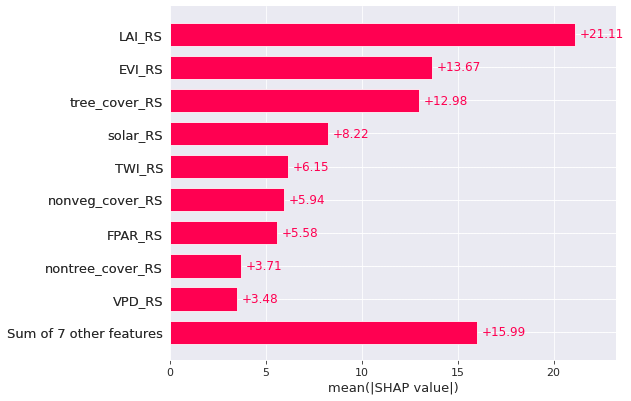

In [17]:
#add names of features
shap_values.feature_names = df.columns.values

# visualize the importances
# shap.plots.waterfall(shap_values[0])
# shap.plots.beeswarm(shap_values)
shap.plots.bar(shap_values)

## Save the model

In [18]:
dump(model, '/g/data/os22/chad_tmp/NEE_modelling/results/models/'+model_name+'_'+model_var+'_RF_LOGO_model.joblib')

['/g/data/os22/chad_tmp/NEE_modelling/results/models/AUS_GPP_RF_LOGO_model.joblib']

## Predict on all the data

In [19]:
y_pred = model.predict(x)

rmse = float(format(np.sqrt(mean_squared_error(y, y_pred)), '.3f'))
print("RMSE:", rmse);

RMSE: 9.648


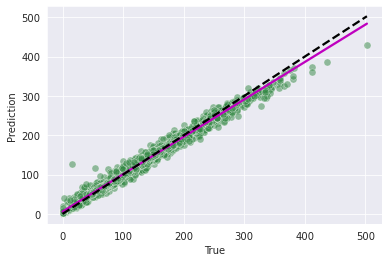

In [20]:
sb.scatterplot(x=y,y=y_pred,color="#338844", edgecolor="white", s=50, lw=1, alpha=0.5)
sb.regplot(x=y, y=y_pred, scatter=False, color='m')
sb.regplot(x=y, y=y, color='black', scatter=False, line_kws={'linestyle':'dashed'});
plt.xlabel('True')
plt.ylabel('Prediction');